In [9]:
import pandas as pd
import numpy as np
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Load Phase-1 dataset
data_path = "phase1_dlp_channel_dataset_rescaled.csv"  # adjust path if needed
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (500, 14)


,batch_id,print_job_id,channel_id,timestamp,resin_type,layer_thickness_um,orientation_deg,support_mode,fit_adjustment_pct,channel_length_mm,channel_diameter_mm,channel_width_mm,measured_flow_mL_per_min,pressure_drop_kPa
0,BATCH_36,JOB_9322,CH_0001,2025-09-08T22:10:48,Resin_A,20,45,manual,0.387,32.292,0.750,2.567,0.926726,0.001529
1,BATCH_16,JOB_1189,CH_0002,2025-09-08T22:25:48,Resin_A,50,90,auto,-0.835,40.593,0.849,1.815,0.927016,0.001148
2,BATCH_4,JOB_9792,CH_0003,2025-09-08T22:40:48,Resin_B,100,60,auto,-1.814,40.377,0.926,0.793,0.927338,0.000911
3,BATCH_2,JOB_2021,CH_0004,2025-09-08T22:55:48,Resin_A,100,60,auto,-1.862,55.466,1.147,3.481,0.928937,0.000515
4,BATCH_48,JOB_8629,CH_0005,2025-09-08T23:10:48,Resin_B,50,90,manual,1.101,56.975,2.737,3.191,1.015756,0.000016


In [10]:
# Features we’ll use
features = [
    "resin_type", "layer_thickness_um", "orientation_deg",
    "support_mode", "fit_adjustment_pct",
    "channel_length_mm", "channel_diameter_mm", "channel_width_mm"
]
target = "measured_flow_mL_per_min"

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42
)

# Preprocessing: categorical (one-hot) + numerical (passthrough)
categorical = ["resin_type", "support_mode"]
numerical = [f for f in features if f not in categorical]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical)
    ]
)

# Base model: RandomForest (we can swap for GPR later if we want)
model = Pipeline([
    ("preprocess", preprocess),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)
print("Baseline model score:", model.score(X_test, y_test))


Baseline model score: 0.9734998039498859


In [11]:
# Define pbounds = search space
pbounds = {
    "layer_thickness_um": (20, 100),
    "orientation_deg": (0, 90),
    "fit_adjustment_pct": (-2.0, 2.0),
    "channel_length_mm": (10.0, 60.0),
    "channel_diameter_mm": (0.5, 3.0),
    "channel_width_mm": (0.5, 5.0)
}

def objective(**params):
    # Create dataframe row for prediction
    row = pd.DataFrame([params])
    # Add defaults for categorical features (fixed for now, or expand pbounds later)
    row["resin_type"] = "Resin_A"
    row["support_mode"] = "auto"
    # Predict flow
    flow_pred = model.predict(row)[0]
    # Target = keep flow close to 1.0 mL/min (our dataset’s nominal mean)
    return -abs(flow_pred - 1.0)


In [12]:
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=20)

print("Best parameters found:", optimizer.max["params"])
print("Best target value:", optimizer.max["target"])


|   iter    |  target   | layer_... | orient... | fit_ad... | channe... | channe... | channe... |
-------------------------------------------------------------------------------------------------
| 1         | -0.072928 | 49.963209 | 85.564287 | 0.9279757 | 39.932924 | 0.8900466 | 1.2019753 |
| 2         | -0.074154 | 24.646688 | 77.955853 | 0.4044600 | 45.403628 | 0.5514612 | 4.8645943 |
| 3         | -0.060930 | 86.595411 | 19.110519 | -1.272700 | 19.170225 | 1.2606056 | 2.8614039 |
| 4         | -0.060165 | 54.555601 | 26.210622 | 0.4474115 | 16.974693 | 1.2303616 | 2.1486282 |
| 5         | -0.031187 | 56.485598 | 70.665836 | -1.201304 | 35.711721 | 1.9810364 | 0.7090268 |
| 6         | -0.049680 | 84.671787 | 31.030823 | 1.2509201 | 26.944671 | 1.5630364 | 2.2792581 |
| 7         | -0.038134 | 37.490623 | 32.345033 | -0.373792 | 22.576408 | 1.6396745 | 3.9513230 |
| 8         | -0.008022 | 66.918416 | 88.277705 | -1.253958 | 15.355078 | 1.8132306 | 1.2179397 |
| 9         | -0.028

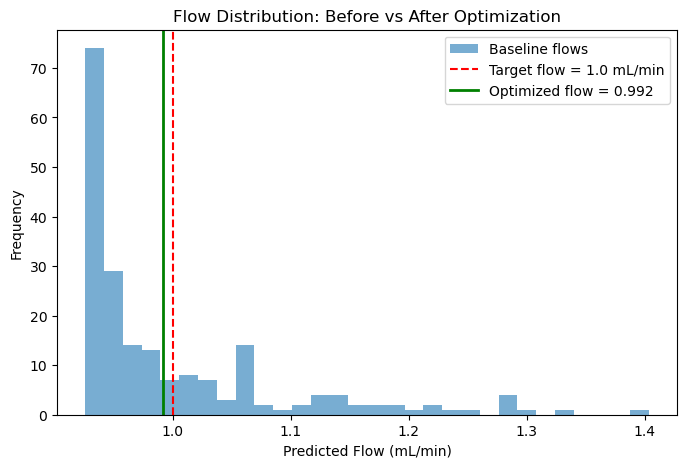

In [13]:
import matplotlib.pyplot as plt

# Generate random samples from search space for baseline prediction
n_samples = 200
random_params = pd.DataFrame({
    "layer_thickness_um": np.random.uniform(20, 100, n_samples),
    "orientation_deg": np.random.uniform(0, 90, n_samples),
    "fit_adjustment_pct": np.random.uniform(-2, 2, n_samples),
    "channel_length_mm": np.random.uniform(10, 60, n_samples),
    "channel_diameter_mm": np.random.uniform(0.5, 3, n_samples),
    "channel_width_mm": np.random.uniform(0.5, 5, n_samples),
    "resin_type": "Resin_A",
    "support_mode": "auto"
})

baseline_flows = model.predict(random_params)

# Best parameters from optimizer
best_params = optimizer.max["params"]
best_row = pd.DataFrame([best_params])
best_row["resin_type"] = "Resin_A"
best_row["support_mode"] = "auto"
optimized_flow = model.predict(best_row)[0]

# Plot histogram comparison
plt.figure(figsize=(8,5))
plt.hist(baseline_flows, bins=30, alpha=0.6, label="Baseline flows")
plt.axvline(1.0, color="red", linestyle="--", label="Target flow = 1.0 mL/min")
plt.axvline(optimized_flow, color="green", linestyle="-", linewidth=2, label=f"Optimized flow = {optimized_flow:.3f}")
plt.xlabel("Predicted Flow (mL/min)")
plt.ylabel("Frequency")
plt.title("Flow Distribution: Before vs After Optimization")
plt.legend()
plt.show()


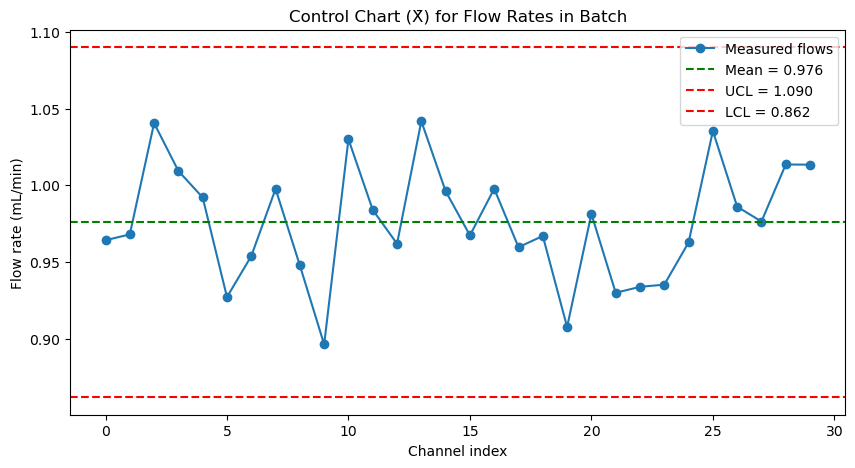

In [14]:
# Simulate a batch of N channels at optimized params
N_batch = 30
flows_batch = []
for i in range(N_batch):
    # Add small random noise to mimic variation across channels
    noisy_row = best_row.copy()
    pred_flow = model.predict(noisy_row)[0]
    noise = np.random.normal(0, 0.05 * pred_flow)  # ~5% variation
    flows_batch.append(pred_flow + noise)

flows_batch = np.array(flows_batch)

# Compute control limits
X_bar = np.mean(flows_batch)
std = np.std(flows_batch, ddof=1)
UCL = X_bar + 3*std
LCL = X_bar - 3*std

# Plot control chart
plt.figure(figsize=(10,5))
plt.plot(flows_batch, marker="o", linestyle="-", label="Measured flows")
plt.axhline(X_bar, color="green", linestyle="--", label=f"Mean = {X_bar:.3f}")
plt.axhline(UCL, color="red", linestyle="--", label=f"UCL = {UCL:.3f}")
plt.axhline(LCL, color="red", linestyle="--", label=f"LCL = {LCL:.3f}")
plt.title("Control Chart (X̄) for Flow Rates in Batch")
plt.xlabel("Channel index")
plt.ylabel("Flow rate (mL/min)")
plt.legend()
plt.show()


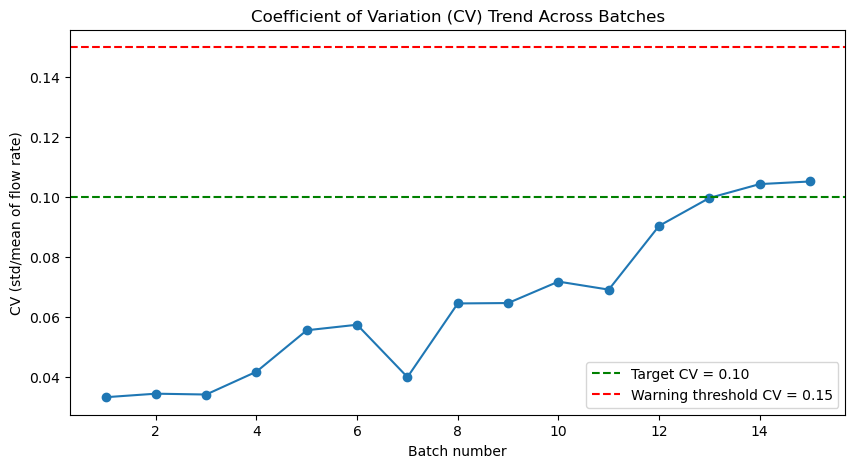

In [15]:
# Simulate multiple batches with slight drift in process variation
n_batches = 15
batch_size = 30
batch_cvs = []

for b in range(n_batches):
    flows = []
    for i in range(batch_size):
        noisy_row = best_row.copy()
        pred_flow = model.predict(noisy_row)[0]
        # Add increasing noise as drift (e.g., resin aging or printer drift)
        noise = np.random.normal(0, (0.03 + 0.005*b) * pred_flow)
        flows.append(pred_flow + noise)
    flows = np.array(flows)
    cv = np.std(flows, ddof=1) / np.mean(flows)
    batch_cvs.append(cv)

# Plot CV trend
plt.figure(figsize=(10,5))
plt.plot(range(1, n_batches+1), batch_cvs, marker="o", linestyle="-")
plt.axhline(0.10, color="green", linestyle="--", label="Target CV = 0.10")
plt.axhline(0.15, color="red", linestyle="--", label="Warning threshold CV = 0.15")
plt.title("Coefficient of Variation (CV) Trend Across Batches")
plt.xlabel("Batch number")
plt.ylabel("CV (std/mean of flow rate)")
plt.legend()
plt.show()
